### Code Generation with a GRU
>
>@danaderp 09.16.20
>

In [87]:
#! pip install sentencepiece
! pip install datasets

     |████████████████████████████████| 147 kB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 17.3 MB 12.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.4 MB 11.8 MB/s eta 0:00:01
     |████████████████████████████████| 243 kB 11.5 MB/s eta 0:00:01
  Created wheel for multiprocess: filename=multiprocess-0.70.10-py3-none-any.whl size=108187 sha256=49cbfd551b8d28ece59402afb8704cbdf1cf2ec48b891cfba6aa538aed51a241
  Stored in directory: /home/jovyan/.cache/pip/wheels/69/a0/aa/14379d16112299afa0b5f8464971648ea2a660a8f6aa1ca088
Successfully built multiprocess


In [98]:
import tensorflow as tf
import numpy as np
import os
import time

In [30]:
import matplotlib.pyplot as plt

In [2]:
import functools 
from operator import or_

In [26]:
from collections import Counter

In [3]:
from scipy import stats

In [4]:
import sentencepiece as spm

In [5]:
import pandas as pd

In [100]:
#export
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [149]:
def params():
    return {
        'dummy_path' : '../../data/dummy/',
        'hyper': {
            'seq_length':100,
            'batch_size':64,
            'buffer_size':10000,
            'rnn_units':1024,
            'epochs':10
        },
        'checkpoint_dir':'../../data/checkpoint_dir/',
        'dataset':'../../data/codesearchnet/clean_java_full.csv',
        'bpe':'../../data/bpe/java_bpe_32k_c',
        'eda':'../../data/codesearchnet/eda/'
    }

In [150]:
params = params()

In [8]:
#tst
params['hyper']['seq_length']

100

In [9]:
params['dataset']

'../../data/codesearchnet/clean_java_full.csv'

# Loading Datasets

In [151]:
java_df = pd.read_csv(params['dataset'])

In [92]:
java_df.head()

,Unnamed: 0,code,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count
0,0,protected final void fastPathOrderedEmit(U val...,134.0,"['protected', 'final', 'void', 'fastPathOrdere...",7.0,src,fastPathOrderedEmit,20.0,3.0,test,131.0
1,1,@CheckReturnValue\n @NonNull\n @Schedule...,63.0,"['@', 'CheckReturnValue', '@', 'NonNull', '@',...",1.0,src,amb,4.0,1.0,test,43.0
2,2,"@SuppressWarnings(""unchecked"")\n @CheckRetu...",107.0,"['@', 'SuppressWarnings', '(', '""unchecked""', ...",3.0,src,ambArray,11.0,1.0,test,82.0
3,3,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",79.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,4.0,1.0,test,50.0
4,4,"@SuppressWarnings({ ""unchecked"", ""rawtypes"" })...",91.0,"['@', 'SuppressWarnings', '(', '{', '""unchecke...",1.0,src,concat,5.0,2.0,test,62.0


In [12]:
# Partitions
df_train = java_df[java_df['partition'] == 'train']
df_valid = java_df[java_df['partition'] == 'valid']
df_test = java_df[java_df['partition'] == 'test']

In [101]:
logging.info("Train Partition Size "+ str(df_train.shape) )
logging.info("Valid Partition Size "+ str(df_valid.shape) )
logging.info("Test Partition Size "+ str(df_test.shape) )

2020-11-10 23:57:58,296 : INFO : Train Partition Size (454273, 12)
2020-11-10 23:57:58,305 : INFO : Valid Partition Size (15321, 11)
2020-11-10 23:57:58,307 : INFO : Test Partition Size (26900, 11)


In [13]:
m_prefix = params['bpe']
sp_bpe = spm.SentencePieceProcessor()
sp_bpe.load(m_prefix +'.model')

True

In [14]:
# encode: text => id
print(sp_bpe.encode_as_pieces('private Hi_Altituted(float j = 00; j++)'))
print(sp_bpe.encode_as_ids('private Hi_Altituted(float j = 00; j++)'))

['▁private', '▁H', 'i', '_', 'Alt', 'it', 'uted', '(', 'float', '▁j', '▁=', '▁0', '0;', '▁j', '++)']
[416, 480, 31899, 31940, 8821, 38, 7784, 31906, 2416, 331, 16, 165, 1483, 331, 672]


In [15]:
code_train = df_train.pop('code')

In [16]:
code_train

26900     protected final void bindIndexed(Configuration...
26901     public void setServletRegistrationBeans(\n\t\t...
26902     public void addServletRegistrationBeans(\n\t\t...
26903     public void setServletNames(Collection<String>...
26904     public void addServletNames(String... servletN...
                                ...                        
481168    public void upgrade() {\n        ByteArrayOutp...
481169    protected static EnvVars getEnvVars(Run run, T...
481170    protected static void insertLabels(CreateConta...
481171    public void setEnabled(boolean enabled) {\n   ...
481172    @Nonnull\n    @Override\n    public NodeProvis...
Name: code, Length: 454273, dtype: object

In [17]:
#Encoding Training Data
#TODO Save this data somewhere!
code_train_bpe = [ sp_bpe.encode_as_ids(method) for method in code_train.values]

In [18]:
df_train['bpe_ids'] = code_train_bpe

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [19]:
#Avg Number of Subwords 
count_subwords = [len(mtd) for mtd in df_train['bpe_ids'].values]

In [20]:
df_train['count_subwords'] = count_subwords

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [21]:
df_train.head(2)

,Unnamed: 0,code_len,code_tokens,cyclomatic_complexity,data_type,method_name,nloc,parameter_count,partition,token_count,bpe_ids,count_subwords
26900,0,80.0,"['protected', 'final', 'void', 'bindIndexed', ...",4.0,src,bindIndexed,11.0,6.0,train,75.0,"[731, 157, 211, 4262, 9890, 31906, 866, 22716,...",92
26901,1,37.0,"['public', 'void', 'setServletRegistrationBean...",1.0,src,setServletRegistrationBeans,6.0,1.0,train,34.0,"[103, 211, 372, 1339, 5320, 4152, 31906, 1209,...",49


# HugginFace Dataset

In [93]:
from datasets import list_datasets, load_dataset, list_metrics, load_metric
from datasets import Dataset

In [89]:
# Print all the available datasets
print(list_datasets())

['aeslc', 'ag_news', 'ai2_arc', 'allocine', 'anli', 'arcd', 'art', 'billsum', 'biomrc', 'blended_skill_talk', 'blimp', 'blog_authorship_corpus', 'bookcorpus', 'boolq', 'break_data', 'c4', 'cfq', 'civil_comments', 'clue', 'cmrc2018', 'cnn_dailymail', 'coarse_discourse', 'com_qa', 'common_gen', 'commonsense_qa', 'compguesswhat', 'conll2000', 'conll2003', 'coqa', 'cornell_movie_dialog', 'cos_e', 'cosmos_qa', 'crd3', 'crime_and_punish', 'csv', 'daily_dialog', 'definite_pronoun_resolution', 'discofuse', 'docred', 'doqa', 'drop', 'eli5', 'emo', 'emotion', 'empathetic_dialogues', 'eraser_multi_rc', 'esnli', 'event2Mind', 'fever', 'flores', 'fquad', 'gap', 'germeval_14', 'gigaword', 'glue', 'guardian_authorship', 'hans', 'hansards', 'hellaswag', 'hotpot_qa', 'hyperpartisan_news_detection', 'imdb', 'iwslt2017', 'jeopardy', 'json', 'kilt_tasks', 'kilt_wikipedia', 'kor_nli', 'lc_quad', 'librispeech_lm', 'lince', 'lm1b', 'math_dataset', 'math_qa', 'matinf', 'mlqa', 'mlsum', 'movie_rationales', 'ms

In [94]:
# Loading from In-Memory Data
hf_dataset_java = Dataset.from_pandas(java_df)

In [96]:
hf_dataset_java.set_format(type='tensorflow', columns=['code'])

In [97]:
features = {x: hf_dataset_java[x].to_tensor(default_value=0, shape=[None, tokenizer.max_len]) for x in ['code']}

MemoryError: Unable to allocate 862. GiB for an array with shape (496494,) and data type <U466265

In [ ]:
# Casting to TF object
tf_dataset_java = hf_dataset_java

## EDA

In [69]:
import pickle

In [22]:
df_train.describe()

,Unnamed: 0,code_len,cyclomatic_complexity,nloc,parameter_count,token_count,count_subwords
count,454273.000000,454273.000000,454273.000000,454273.000000,454273.000000,454273.000000,454273.000000
mean,14874.408877,112.688527,3.803334,14.980697,1.631616,107.098163,145.445378
std,8710.470899,233.378681,13.074112,32.522032,1.390295,226.699784,376.794328
min,0.000000,20.000000,1.000000,2.000000,0.000000,7.000000,20.000000
25%,7276.000000,42.000000,1.000000,6.000000,1.000000,38.000000,50.000000
50%,14851.000000,66.000000,2.000000,9.000000,1.000000,62.000000,80.000000
75%,22426.000000,121.000000,4.000000,16.000000,2.000000,116.000000,149.000000
max,29999.000000,68278.000000,4434.000000,11325.000000,54.000000,68274.000000,113356.000000


In [23]:
stats.median_absolute_deviation(count_subwords)

54.856199999999994

In [24]:
# Frequent Characters
train_tokens = df_train.code_tokens.values

In [51]:
train_vocab_tokens = [ eval(method)  for method in train_tokens ] #Evaluating given tokens

In [52]:
train_counter_tokens = [ Counter(method) for method in train_vocab_tokens ] #Counting the words

In [53]:
train_counter = functools.reduce(lambda a,b : a+b, train_counter_tokens ) ## [Warning! Time Consuming]

In [72]:
#Persisting the counter object
with open(params['eda']+'word_counts.pickle', 'wb') as outputfile:
    pickle.dump(train_counter, outputfile)

In [108]:
len(list(train_counter)) #Size of counter

1763464

In [109]:
len(set(train_counter)) #Size of counter

1763464

In [110]:
train_counter.size()

AttributeError: 'Counter' object has no attribute 'size'

In [99]:
train_counter.most_common(100)

[('(', 5553188),
 (')', 5551263),
 ('.', 3679908),
 (';', 3180563),
 (',', 1889239),
 ('}', 1603293),
 ('{', 1602994),
 ('=', 1324787),
 ('if', 708318),
 ('return', 530149),
 ('<', 515771),
 ('>', 477821),
 ('String', 469968),
 ('new', 469634),
 ('null', 428538),
 ('public', 371174),
 ('+', 349370),
 ('[', 303312),
 (']', 303300),
 ('int', 262989),
 ('==', 261485),
 ('0', 248776),
 ('final', 246884),
 ('i', 220693),
 (':', 209715),
 ('this', 203371),
 ('!=', 176567),
 ('else', 164995),
 ('void', 156722),
 ('e', 154430),
 ('1', 143624),
 ('@', 136596),
 ('throw', 129497),
 ('for', 127133),
 ('static', 123778),
 ('&&', 122509),
 ("'", 119277),
 ('get', 106127),
 ('length', 100921),
 ('-', 100651),
 ('result', 99919),
 ('throws', 98850),
 ('!', 93540),
 ('?', 93047),
 ('try', 89707),
 ('catch', 89229),
 ('case', 85344),
 ('append', 85061),
 ('value', 85055),
 ('boolean', 84247),
 ('Object', 83422),
 ('List', 80880),
 ('Override', 78332),
 ('T', 76526),
 ('add', 76368),
 ('true', 76009),
 

In [146]:
chars, counts = zip(*train_counter.most_common(10))
indices = np.arange(len(counts))

In [111]:
print(chars, counts)

('(', ')', '.', ';', ',', '}', '{', '=', 'if', 'return', '<', '>', 'String', 'new', 'null', 'public', '+', '[', ']', 'int', '==', '0', 'final', 'i', ':', 'this', '!=', 'else', 'void', 'e', '1', '@', 'throw', 'for', 'static') (5553188, 5551263, 3679908, 3180563, 1889239, 1603293, 1602994, 1324787, 708318, 530149, 515771, 477821, 469968, 469634, 428538, 371174, 349370, 303312, 303300, 262989, 261485, 248776, 246884, 220693, 209715, 203371, 176567, 164995, 156722, 154430, 143624, 136596, 129497, 127133, 123778)


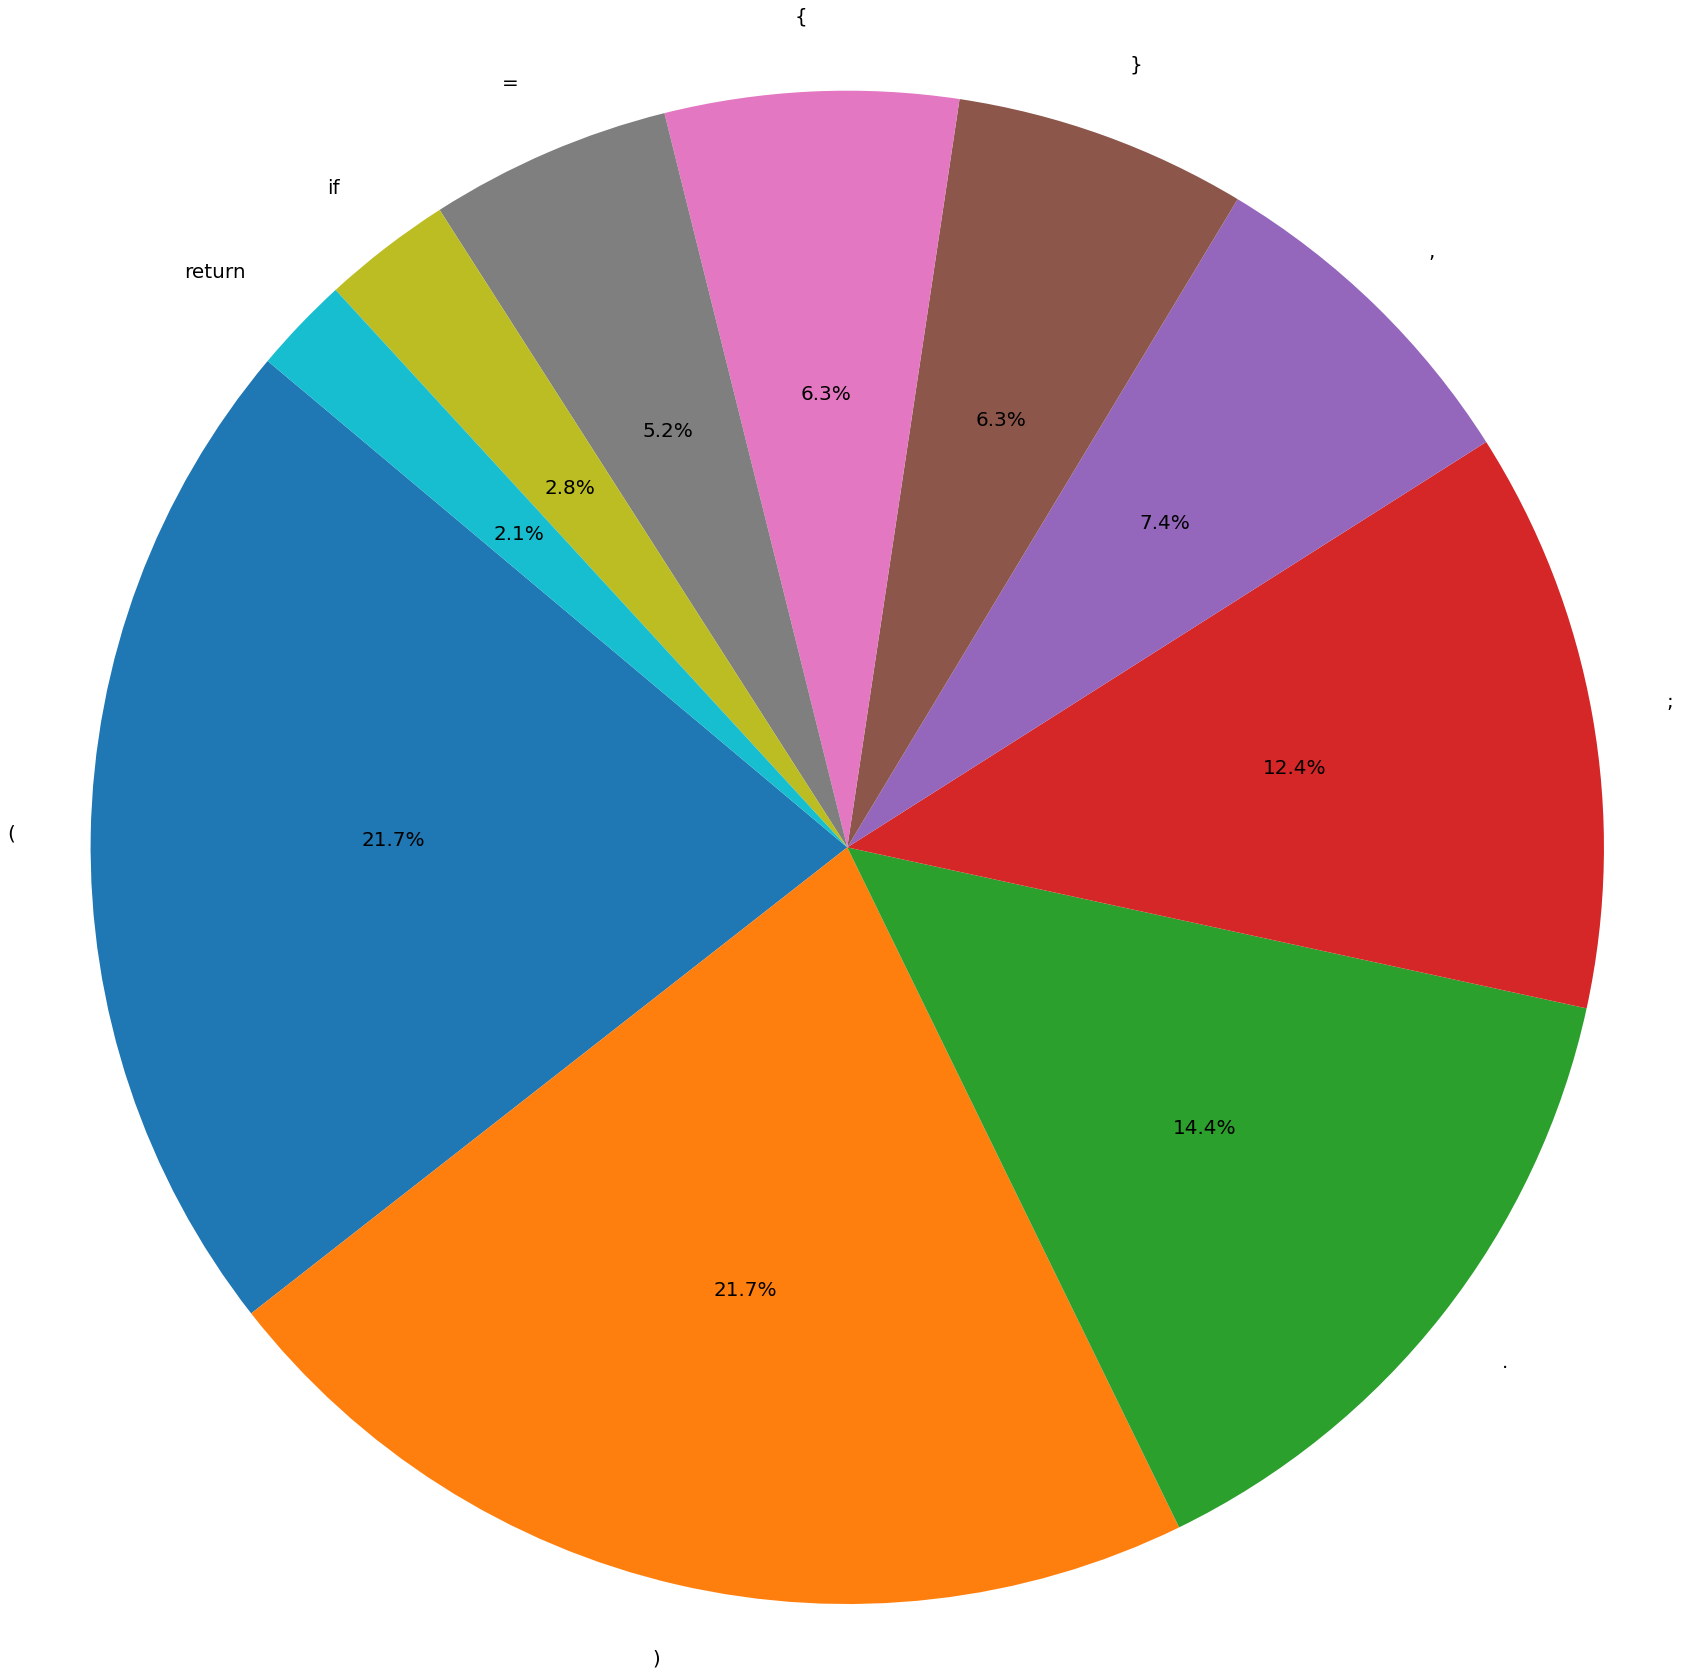

In [148]:
#Most common distribution of tokens
fig = plt.figure(figsize =(30, 30)) 
plt.rcParams.update({'font.size': 20})
plt.pie([float(v) for v in counts], labels=[k for k in chars], autopct='%1.1f%%', startangle=140)
#plt.figure(figsize=(30, 10))
plt.axis('equal')
plt.show()
fig.savefig('TokenDistribution10.png')

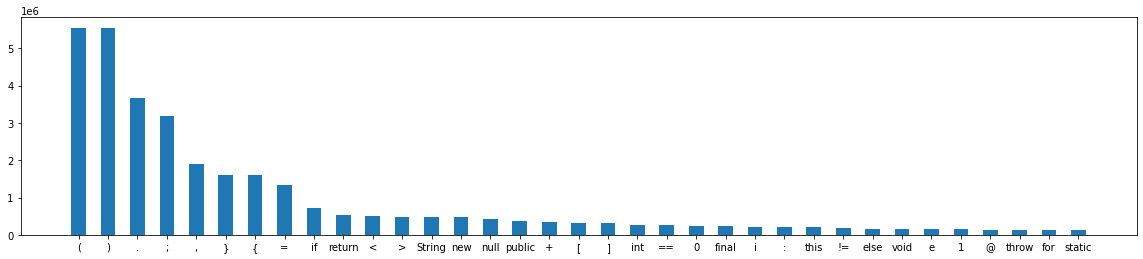

In [84]:
plt.figure(figsize=(20, 4))
plt.bar(indices, counts, 0.5)
plt.xticks(indices, chars);

In [172]:
set(['p', 'p', 'aa']) #tst

{'aa', 'p'}

In [ ]:
vocab_tokens = functools.reduce(or_ , vocab_tokens)

In [ ]:
len(vocab_tokens)

In [153]:
MAX_SEQ = 250 ## Max sequence of subwords

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f852deb0890>,
      dtype=object)

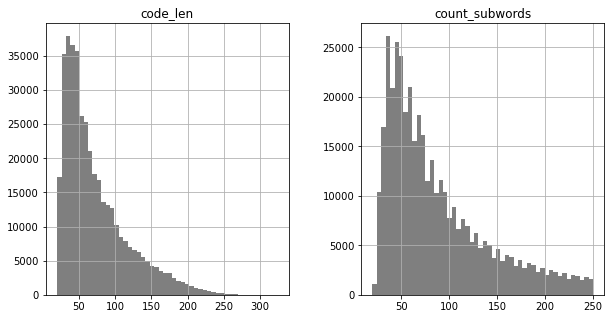

In [154]:
df_train[df_train['count_subwords']<=MAX_SEQ].hist(column=['count_subwords', 'code_len'],color='k',bins=50,figsize=[10,5],alpha=0.5)

In [123]:
sp_bpe.encode_as_ids('Hola lol')

[480, 96, 31900, 255, 31903]

In [159]:
len(code_train_bpe[400][:68])

68

In [162]:
code_train_bpe = [subword[:MAX_SEQ] for subword in df_train.bpe_ids.values] #Trimming Until Threshold 

In [ ]:
code_train_dataset = tf.data.Dataset.from_tensor_slices(code_train_bpe)

In [154]:
#rm
path_to_file = tf.keras.utils.get_file(params['dummy_path'] + 'shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

In [155]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print ('Length of text: {} characters'.format(len(text)))

Length of text: 1115394 characters


In [156]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [157]:
# The unique characters in the file
vocab = sorted(set(text))
print ('{} unique characters'.format(len(vocab)))

65 unique characters


## Vectorize the text

In [158]:
# Creating a mapping from unique characters to indices
char2idx = {u:i for i, u in enumerate(vocab)}
idx2char = np.array(vocab)

text_as_int = np.array([char2idx[c] for c in text])

In [160]:
text_as_int

array([18, 47, 56, ..., 45,  8,  0])

In [18]:
print('{')
for char,_ in zip(char2idx, range(20)):
    print('  {:4s}: {:3d},'.format(repr(char), char2idx[char]))
print('  ...\n}')

{
  '\n':   0,
  ' ' :   1,
  '!' :   2,
  '$' :   3,
  '&' :   4,
  "'" :   5,
  ',' :   6,
  '-' :   7,
  '.' :   8,
  '3' :   9,
  ':' :  10,
  ';' :  11,
  '?' :  12,
  'A' :  13,
  'B' :  14,
  'C' :  15,
  'D' :  16,
  'E' :  17,
  'F' :  18,
  'G' :  19,
  ...
}


In [19]:
print ('{} ---- characters mapped to int ---- > {}'.format(repr(text[:13]), text_as_int[:13]))

'First Citizen' ---- characters mapped to int ---- > [18 47 56 57 58  1 15 47 58 47 64 43 52]


### The prediction task
Given a character, or a sequence of characters, what is the most probable next character? This is the task we're training the model to perform. The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

In [161]:
# The maximum length sentence we want for a single input in characters
seq_length = params['hyper']['seq_length']
examples_per_epoch = len(text)//(seq_length+1) 

In [162]:
# Create training examples / targets
char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int) #subs char_dataset for subword

In [165]:
for i in char_dataset.take(5):
    print(idx2char[i.numpy()])

F
i
r
s
t


In [30]:
# The batch method lets us easily convert these individual characters to sequences of the desired size.
sequences = char_dataset.batch(seq_length+1, drop_remainder=True)

In [31]:
for item in sequences.take(5):
    print(repr(''.join(idx2char[item.numpy()])))

'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


In [32]:
#For each sequence, duplicate and shift it to form the input and target text by using the map method to apply a simple function to each batch:
def split_input_target(chunk):
    input_text = chunk[:-1]
    target_text = chunk[1:]
    return input_text, target_text

In [33]:
dataset = sequences.map(split_input_target)

In [34]:
for input_example, target_example in  dataset.take(1):
    print ('Input data: ', repr(''.join(idx2char[input_example.numpy()])))
    print ('Target data:', repr(''.join(idx2char[target_example.numpy()])))

Input data:  'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target data: 'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


In [37]:
#Each index of these vectors are processed as one time step. For the input at time step 0, the model receives the index for "F" and trys to predict the index for "i" as the next character. 
#At the next timestep, it does the same thing but the RNN considers the previous step context in addition to the current input character.
for i, (input_idx, target_idx) in enumerate(zip(input_example[:5], target_example[:5])):
    print("Step {:4d}".format(i))
    print("  input: {} ({:s})".format(input_idx, repr(idx2char[input_idx])))
    print("  expected output: {} ({:s})".format(target_idx, repr(idx2char[target_idx])))

Step    0
  input: 18 ('F')
  expected output: 47 ('i')
Step    1
  input: 47 ('i')
  expected output: 56 ('r')
Step    2
  input: 56 ('r')
  expected output: 57 ('s')
Step    3
  input: 57 ('s')
  expected output: 58 ('t')
Step    4
  input: 58 ('t')
  expected output: 1 (' ')


### Create training batches
Buffer size to shuffle the dataset
(TF data is designed to work with possibly infinite sequences,
so it doesn't attempt to shuffle the entire sequence in memory. Instead,
it maintains a buffer in which it shuffles elements).

In [45]:
BATCH_SIZE = params['hyper']['batch_size'] # Batch size
BUFFER_SIZE = params['hyper']['buffer_size']

In [46]:
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# Building the model

In [52]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256 ##<----------[Hyperparams]

# Number of RNN units
rnn_units =  params['hyper']['rnn_units']

In [53]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim,
                              batch_input_shape=[batch_size, None]),
        tf.keras.layers.GRU(
                        rnn_units,
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform'),
        tf.keras.layers.Dense(vocab_size)
    ])
    return model

For each character the model looks up the embedding, runs the GRU one timestep with the embedding as input, and applies the dense layer to generate logits predicting the log-likelihood of the next character:

In [54]:
model = build_model(
    vocab_size = len(vocab),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units,
    batch_size=BATCH_SIZE
)

# Running the model

In [55]:
#Checking the shape of the output
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 65) # (batch_size, sequence_length, vocab_size)


In the above example the sequence length of the input is 100 but the model can be run on inputs of any length:

In [56]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (64, None, 256)           16640     
_________________________________________________________________
gru (GRU)                    (64, None, 1024)          3938304   
_________________________________________________________________
dense (Dense)                (64, None, 65)            66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [57]:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices,axis=-1).numpy()

In [58]:
sampled_indices

array([30,  2, 28, 43, 32,  6, 15, 39, 10, 62,  5, 52, 47, 28, 35, 37, 48,
       36, 37, 64, 13,  8, 18, 15, 33, 47, 23, 21, 13,  7, 49, 43, 34, 63,
       23, 62, 55, 62, 41, 25, 40,  6, 50, 19, 12, 23, 34,  6, 51, 55,  6,
       20, 21,  7, 17, 30, 42, 28, 57,  3, 18,  8,  0, 34, 40, 59, 42, 25,
        4,  7, 59, 54, 15, 49,  7, 62, 34, 58,  1, 51, 25,  3, 18, 18,  0,
        5,  9, 25,  5, 14, 64,  8, 62, 57, 28,  4, 44,  9,  1, 15])

Decode these to see the text predicted by this untrained model:

In [59]:
print("Input: \n", repr("".join(idx2char[input_example_batch[0]])))
print()
print("Next Char Predictions: \n", repr("".join(idx2char[sampled_indices ])))

Input: 
 "ountenances.\n\nSICINIUS:\n'Tis this slave;--\nGo whip him, 'fore the people's eyes:--his raising;\nNothi"

Next Char Predictions: 
 "R!PeT,Ca:x'niPWYjXYzA.FCUiKIA-keVyKxqxcMb,lG?KV,mq,HI-ERdPs$F.\nVbudM&-upCk-xVt mM$FF\n'3M'Bz.xsP&f3 C"


# Training The model

In [60]:
def loss(labels, logits):
    return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

In [61]:
example_batch_loss  = loss(target_example_batch, example_batch_predictions)

In [62]:
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("scalar_loss:      ", example_batch_loss.numpy().mean())

Prediction shape:  (64, 100, 65)  # (batch_size, sequence_length, vocab_size)
scalar_loss:       4.173104


In [63]:
#Configure the training procedure using the tf.keras.Model.compile method. We'll use tf.keras.optimizers.Adam with default arguments and the loss function.
model.compile(optimizer='adam', loss=loss)

## Configure checkpoints

In [67]:
# Directory where the checkpoints will be saved
checkpoint_dir = params['checkpoint_dir']
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [68]:
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

## Execute Training

In [71]:
EPOCHS = params['hyper']['epochs']

In [72]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/10
172/172 [==============================] - 243s 1s/step - loss: 2.6501
Epoch 2/10
172/172 [==============================] - 246s 1s/step - loss: 1.9590
Epoch 3/10
172/172 [==============================] - 247s 1s/step - loss: 1.6893
Epoch 4/10
172/172 [==============================] - 245s 1s/step - loss: 1.5404
Epoch 5/10
172/172 [==============================] - 247s 1s/step - loss: 1.4535
Epoch 6/10
172/172 [==============================] - 246s 1s/step - loss: 1.3947
Epoch 7/10
172/172 [==============================] - 244s 1s/step - loss: 1.3486
Epoch 8/10
172/172 [==============================] - 247s 1s/step - loss: 1.3115
Epoch 9/10
172/172 [==============================] - 248s 1s/step - loss: 1.2756
Epoch 10/10
172/172 [==============================] - 245s 1s/step - loss: 1.2439


# Generating Sequences

In [73]:
tf.train.latest_checkpoint(checkpoint_dir)

'../../data/checkpoint_dir/ckpt_10'

To run the model with a different batch_size, we need to rebuild the model and restore the weights from the checkpoint.

In [74]:
model = build_model(vocab_size, embedding_dim, rnn_units, batch_size=1) #Rebuilding the model

In [75]:
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))

In [76]:
model.build(tf.TensorShape([1, None]))

In [77]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (1, None, 256)            16640     
_________________________________________________________________
gru_1 (GRU)                  (1, None, 1024)           3938304   
_________________________________________________________________
dense_1 (Dense)              (1, None, 65)             66625     
Total params: 4,021,569
Trainable params: 4,021,569
Non-trainable params: 0
_________________________________________________________________


In [78]:
def generate_text(model, start_string):
    # Evaluation step (generating text using the learned model)

    # Number of characters to generate
    num_generate = 1000

    # Converting our start string to numbers (vectorizing)
    input_eval = [char2idx[s] for s in start_string]
    input_eval = tf.expand_dims(input_eval, 0)

    # Empty string to store our results
    text_generated = []

    # Low temperatures results in more predictable text.
    # Higher temperatures results in more surprising text.
    # Experiment to find the best setting.
    temperature = 1.0

    # Here batch size == 1
    model.reset_states()
    for i in range(num_generate):
        predictions = model(input_eval)
        # remove the batch dimension
        predictions = tf.squeeze(predictions, 0)

        # using a categorical distribution to predict the character returned by the model
        predictions = predictions / temperature
        predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

        # We pass the predicted character as the next input to the model
        # along with the previous hidden state
        input_eval = tf.expand_dims([predicted_id], 0)

        text_generated.append(idx2char[predicted_id])

    return (start_string + ''.join(text_generated))

In [79]:
print(generate_text(model, start_string=u"ROMEO: "))

ROMEO: the unsuit of state
To puy him beholding these sentin the eye sweet,
For then thus take my wrong im of a tunning nose,
My poor enty busy; but they will rush not Laurely looks!
Since at hand, my lord, this way I mean goo last,
But citcuse better my pack in heaven;
'Tis way done tell your good stilk,
Which whom he be post, upon theur grief as I no done.

JOHN OF GAUNT:
O, let the lick, the other's nyed with
Birothop-gots: tickless he are mine opinion.

AEdile:
Perchance believed: it is no noble.

ISABELLA:
O Romeo? a son, for Imendeed my sour!

LADY CAPULET:
A match'd at me, the mountain arms.

First Killan:
Within this friend trad it in your foe.

KATHARINA:
For tears, and single him of my promise to marry.

BENVOLIO:
Think you, sir, I am pluck'd to see ye
Angel rather hang of honour,
I will that it had rather so awated,
Never-woour master of what much struck swixts for his past
And serely't now a pair of my success,
hy loss returns than your death, pirght be round to her;
And so

In [ ]:
The<\s><\s>excelent<\s>pipeline <\n>\n
<\t><\t>The exc pop <\n>\n
